# Getting started with `sbi`

In this tutorial, you will learn the basics of the `sbi` toolbox. Here is a code-snippet that you will learn to understand:

```python
from sbi.inference import NPE
from sbi.analysis import pairplot


num_simulations = 1000
theta = prior.sample((num_simulations,))
x = simulate(theta)

inference = NPE(prior)
posterior_net = inference.append_simulations(theta, x).train()
posterior = inference.build_posterior()
posterior_theta = posterior.sample((100,), x=x_o)
pairplot(posterior_theta)
```

The overall goal of simulation-based inference is to algorithmically identify parameters which are consistent with data and prior knowledge. To do so, `sbi` uses Bayesian inference:

$$
p(\theta | x_o) \propto p(x_o | \theta) p(\theta)
$$

The _prior_ $p(\theta)$ is a probability distribution which constraint model parameters. The likelihood $p(x_o | \theta)$ is implemented by a _simulator_. It takes parameters as input and returns simulation outputs $x$. The `sbi` toolbox uses the prior and the simulator to compute the posterior $p(\theta | x)$, which captures parameters that are consistent with _observations_ $x_o$.

Let's see how `sbi` achieves this!

## Defining the simulator and prior

As an illustrative example, we consider a _simulator_ that takes in 3 parameters ($\theta$). For simplicity, the _simulator_ outputs simulations of the same dimensionality and adds 1.0 and some Gaussian noise to the parameter set. 

> Note: Here, we are using this simple toy simulator. In practice, the simulator can be
anything that takes parameters and returns simulated data. The data simulation process is
decoupled from the algorithms implemented in the `sbi` package. That is, you can
simulate your data beforehand, e.g., on a cluster or using a different programming
language or environment. All that `sbi` needs is a `Tensor` of parameters `theta` and
corresponding simulated data `x`.

In [1]:
import torch

_ = torch.manual_seed(0)

num_dim = 3
def simulator(theta):
    # Linear Gaussian.
    return theta + 1.0 + torch.randn_like(theta) * 0.1

For the 3-dimensional parameter space we consider a uniform _prior_ between [-2,2].

In [2]:
from sbi.utils import BoxUniform

prior = BoxUniform(low=-2 * torch.ones(num_dim), high=2 * torch.ones(num_dim))

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


The `sbi` toolbox uses neural networks to learn the relationship between parameters and data. In this exampmle, we will use neural perform posterior estimation (NPE). To run NPE, we first instatiate a trainer, which we call `inference`:

In [3]:
from sbi.inference import NPE

inference = NPE(prior=prior)

> You can find all implemented methods [here](https://sbi.readthedocs.io/en/latest/tutorials/16_implemented_methods.html). You can also implement the training loop youself, see [here](https://sbi.readthedocs.io/en/latest/advanced_tutorials/18_training_interface.html).

The neural networks in `sbi` are trained on simulations, or more specifically, pairs of parameters $\theta$ which we sample from the _prior_ and corresponding simulations $x = \mathrm{simulator} (\theta)$. Let's generate such a dataset:

In [4]:
num_simulations = 2000
theta = prior.sample((num_simulations,))
x = simulator(theta)
print("theta.shape", theta.shape)
print("x.shape", x.shape)

theta.shape torch.Size([2000, 3])
x.shape torch.Size([2000, 3])


> If you already have your own parameters, simulation pairs which were generated elsewhere (e.g., on a compute cluster), you would add them here. The `sbi` helper function called `simulate_for_sbi` allows to parallelize your code with `joblib`.

We then pass the simulated data to the inference object. Both `theta` and `x` should be a `torch.Tensor` of type `float32`.

In [5]:
inference = inference.append_simulations(theta, x)

Next, we train the neural network to learn the association between the simulated data and the underlying parameters:

In [6]:
density_estimator = inference.train()

 Neural network successfully converged after 62 epochs.

Finally, we use this _density estimator_ to build an estimator for the posterior distribution.

> For NPE, you can also use the `density_estimator` as posterior. The `DirectPosterior` (which is returned by `build_posterior`) only adds convenience functions (e.g., MAP) and it automatically rejects posterior samples which are outside of the prior bounds.

In [7]:
posterior = inference.build_posterior()

print(posterior)

Posterior p(θ|x) of type DirectPosterior. It samples the posterior network and rejects samples that
            lie outside of the prior bounds.


## Inferring the posterior

Let's say we have made some observation $x_{obs}$ for which we now want to infer the posterior:

In [8]:
x_obs = torch.as_tensor([0.8, 0.6, 0.4])

The `posterior_estimator` can then be used to sample parameters $\theta$ from the posterior via `.sample()`, i.e., parameters that are likely given the observation $x$. We can also get log-probabilities under the posterior via `.log_prob()`. 

For example, given the observation $x_{obs}$, we can sample from the posterior $p(\theta|x_{obs})$ as follows:

In [9]:
samples = posterior.sample((10000,), x=x_obs)

Drawing 10000 posterior samples for 1 observations:   0%|          | 0/10000 [00:00<?, ?it/s]

Note that we can infer the posterior distribution for any observation $x_{obs}$ without having to run new simulations and without having to re-train. This property of `sbi` algorithms is called _amortization_.

## Visualizing the posterior

We can then visualize these posterior samples. The `pairplot` function visualizes all
univariate marginals on the diagnonal and every combination of
pairwise marginals on the upper offdiagonal:

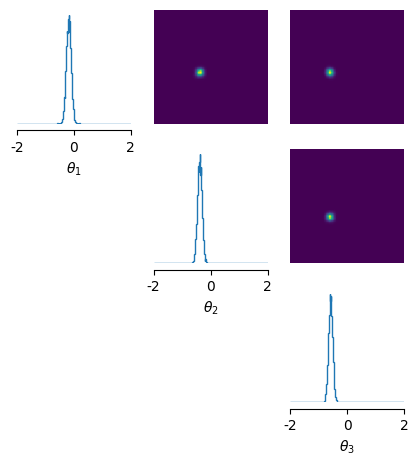

In [10]:
from sbi.analysis import pairplot

_ = pairplot(
    samples,
    limits=[[-2, 2], [-2, 2], [-2, 2]],
    figsize=(5, 5),
    labels=[r"$\theta_1$", r"$\theta_2$", r"$\theta_3$"]
)

## Assessing the predictive performance of the posterior

Congrats, you have just performed Bayesian inference with the `sbi` toolbox!

But, how do we know that the posterior is correct? The `sbi` toolbox implements a wide range
of methods that diagnose potential issues (more detail [here](https://sbi.readthedocs.io/en/latest/how_to_guide/14_choose_diagnostic_tool.html)). For this tutorial,
we will show only a brief heuristic check: We check whether posterior samples, when simulated,
match the observed data. Such tests are called _Posterior Predictive Checks (PPC)_. Let's
simulate posterior samples:

In [11]:
theta_posterior = posterior.sample((10000,), x=x_obs)  # Sample from posterior.
x_predictive = simulator(theta_posterior)  # Simulate data from posterior.

And we can check whether posterior samples roughly match the observation:

In [12]:
print("Posterior predictives: ", torch.mean(x_predictive, axis=0))
print("Observation: ", x_obs)

Posterior predictives:  tensor([0.8128, 0.6147, 0.4083])
Observation:  tensor([0.8000, 0.6000, 0.4000])


Indeed, the posterior predictives are roughly centered around the observation. For any real-world application, we strongly recommend additional checks as described in [this how-to guide](https://sbi.readthedocs.io/en/latest/how_to_guide/14_choose_diagnostic_tool.html).

## Next steps

This tutorial provided a brief overview of the capabilities of the `sbi` toolbox. Next, we recommend that you check out the tutorial on the [full Bayesian workflow with `sbi`](https://sbi.readthedocs.io/en/latest/tutorials/01_Bayesian_workflow.html). Alternatively, you can check our [how-to guide](https://sbi.readthedocs.io/en/latest/how_to_guide.html) for brief tutorials on specific features, or you can read our [API reference](https://sbi.readthedocs.io/en/latest/sbi.html), which provides a complete list of all features in the `sbi` toolbox.